## Imports

In [78]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats

import matplotlib.pyplot as plt
import zetta_utils as zt 

## Configurações

In [79]:
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'monospace'

In [80]:
from pathlib import Path

# Carrega o .env do diretório atual
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

# Debug: verifica se as variáveis foram carregadas
print(f"DB_HOST: {db_host}")
print(f"DB_USER: {db_user}")
print(f"DB_NAME: {db_name}")

DB_HOST: 177.105.35.239
DB_USER: mgi_pwbi
DB_NAME: dw_mgi


In [81]:
connection_string = f'postgresql://{db_user}:{db_password}@{db_host}/{db_name}'
engine = create_engine(connection_string)


## Leitura dos dados 

In [82]:
regioes = ['centro_oeste', 'norte', 'nordeste', 'sudeste', 'sul']
dfs = []

sql_template = """
WITH similaridade_imoveis AS (
	SELECT
		DISTINCT ON (s.cod_imovel)
		s.id, s.id_vizinhanca_sigef, s.cod_imovel, di.idt_municipio, di.estado,
		s.tipo_imovel, s.status_imovel, s.data_cadastro_imovel,
		CASE
			WHEN round(di.num_modulo_fiscal::NUMERIC, 4) <= 4::NUMERIC THEN 'Pequeno'
			WHEN round(di.num_modulo_fiscal::NUMERIC, 4) <= 15::NUMERIC THEN 'Médio'
			ELSE 'Grande'
		END AS class_tam_imovel,
		s.area_intersecao_ha, s.area_sicar_ha, s.area_sigef_agregado_ha,
		(dp.cod_cpf_cnpj = sv.cod_cpf_cnpj) AS igualdade_cpf,
		s.indice_jaccard
	FROM cruzamentos.mv_similaridade_sicar_sigef_{regiao} s
	JOIN regularizacao_ambiental.dim_imovel di ON di.cod_imovel = s.cod_imovel
	JOIN regularizacao_ambiental.rel_imovel_proprietario rip ON rip.idt_imovel = di.idt_imovel
	JOIN regularizacao_ambiental.dim_proprietario dp ON dp.idt_proprietario = rip.idt_proprietario
	JOIN regularizacao_fundiaria.mv_sigef_vizinhanca_{regiao} sv ON sv.id = s.id_vizinhanca_sigef
	WHERE s.tipo_imovel = 'IRU'
	ORDER BY s.cod_imovel, s.indice_jaccard DESC, (CASE WHEN dp.cod_cpf_cnpj = sv.cod_cpf_cnpj THEN 0 ELSE 1 END), s.id_vizinhanca_sigef
),
desmatamento_agregado AS (
	SELECT
		i.cod_imovel,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2008), 0) AS d2008,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2009), 0) AS d2009,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2010), 0) AS d2010,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2011), 0) AS d2011,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2012), 0) AS d2012,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2013), 0) AS d2013,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2014), 0) AS d2014,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2015), 0) AS d2015,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2016), 0) AS d2016,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2017), 0) AS d2017,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2018), 0) AS d2018,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2019), 0) AS d2019,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2020), 0) AS d2020,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2021), 0) AS d2021,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2022), 0) AS d2022,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2023), 0) AS d2023,
		COALESCE(SUM(i.area_imovel_desmat_ha) FILTER (WHERE i.ano = 2024), 0) AS d2024
	FROM cruzamentos.mv_imoveis_simi_geo_cpf_cnpj_desmat_{regiao} i
	WHERE i.cod_imovel IN (SELECT cod_imovel FROM similaridade_imoveis) 
	GROUP BY i.cod_imovel
)
SELECT 
    si.*,
    '{regiao}' as regiao,
    de.d2008, de.d2009, de.d2010, de.d2011, de.d2012, de.d2013, de.d2014, de.d2015, 
    de.d2016, de.d2017, de.d2018, de.d2019, de.d2020, de.d2021, de.d2022, de.d2023, de.d2024
FROM similaridade_imoveis si
LEFT JOIN desmatamento_agregado de ON de.cod_imovel = si.cod_imovel;
"""

print("Iniciando extração das regiões...")

for regiao in regioes:
    try:
        print(f"Processando: {regiao}...")
        
        query_formatada = sql_template.format(regiao=regiao)
        
        df_temp = pd.read_sql(query_formatada, engine)
        
        if not df_temp.empty:
            dfs.append(df_temp)
            print(f"  -> {len(df_temp)} registros encontrados.")
        else:
            print(f"  -> Nenhum registro encontrado para {regiao}.")
            
    except Exception as e:
        print(f"Erro ao processar {regiao}: {e}")

# Consolida tudo
if dfs:
    df = pd.concat(dfs, ignore_True=True)
    print(f"\nConcluído! Total de registros: {len(df)}")
    df.to_csv('similaridade_sicar_sigef_brasil.csv', index=False)
else:
    print("Nenhum dado retornado.")

Iniciando extração das regiões...
Processando: centro_oeste...
Erro ao processar centro_oeste: (psycopg2.errors.UndefinedTable) relation "regularizacao_ambiental.dim_imovel" does not exist
LINE 16:  JOIN regularizacao_ambiental.dim_imovel di ON di.cod_imovel...
               ^

[SQL: 
WITH similaridade_imoveis AS (
	SELECT
		DISTINCT ON (s.cod_imovel)
		s.id, s.id_vizinhanca_sigef, s.cod_imovel, di.idt_municipio, di.estado,
		s.tipo_imovel, s.status_imovel, s.data_cadastro_imovel,
		CASE
			WHEN round(di.num_modulo_fiscal::NUMERIC, 4) <= 4::NUMERIC THEN 'Pequeno'
			WHEN round(di.num_modulo_fiscal::NUMERIC, 4) <= 15::NUMERIC THEN 'Médio'
			ELSE 'Grande'
		END AS class_tam_imovel,
		s.area_intersecao_ha, s.area_sicar_ha, s.area_sigef_agregado_ha,
		(dp.cod_cpf_cnpj = sv.cod_cpf_cnpj) AS igualdade_cpf,
		s.indice_jaccard
	FROM cruzamentos.mv_similaridade_sicar_sigef_centro_oeste s
	JOIN regularizacao_ambiental.dim_imovel di ON di.cod_imovel = s.cod_imovel
	JOIN regularizacao_ambiental.

In [83]:
df = pd.read_csv('similaridade_sicar_sigef_brasil.csv', dtype={'igualdade_cpf': 'boolean'})

In [84]:
df.head()

,regiao_analise,id,id_vizinhanca_sigef,cod_imovel,idt_municipio,estado,tipo_imovel,status_imovel,data_cadastro_imovel,class_tam_imovel,...,d2015,d2016,d2017,d2018,d2019,d2020,d2021,d2022,d2023,d2024
0,centro_oeste,1,4254,DF-5300108-0000AE7221F4458582BE077E36495213,5300108,DF,IRU,AT,2019-05-14 19:30:08.576,Pequeno,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,centro_oeste,3,104768,DF-5300108-000246B53E6048558354E03CA022873A,5300108,DF,IRU,AT,2019-12-12 10:53:36.353,Pequeno,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,centro_oeste,4,83470,DF-5300108-0012FAB5934B416386711DBD527BD708,5300108,DF,IRU,AT,2025-05-23 08:31:22.331,Grande,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,centro_oeste,5,21259,DF-5300108-00152EAC5FCF453B845A5097E3336B64,5300108,DF,IRU,AT,2015-07-01 20:23:54.907,Grande,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,centro_oeste,6,129143,DF-5300108-001C3919F6B4464C838FFF35E022B147,5300108,DF,IRU,AT,2016-05-02 18:52:52.896,Pequeno,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Transformações

### Substuição de valores

In [85]:
df['regiao_analise'] = df['regiao_analise'].replace({'centro_oeste': 'Centro-Oeste', 'sudeste': 'Sudeste', 'nordeste': 'Nordeste', 'norte': 'Norte', 'sul': 'Sul'})

### Renomeação de colunas

In [86]:
df.rename(columns={'estado':'uf'}, inplace=True)

### Transformação para percentual

In [87]:
df['indice_jaccard'] = df['indice_jaccard']*100

### Criação de colunas

In [88]:
bins = [0, 25, 50, 85, 100]
labels = ["0-25%", "25-50%", "50-85%", "85-100%"]

df["faixa_jaccard"] = pd.cut(
    df["indice_jaccard"], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

### Converter data para datetime

In [89]:
df['data_cadastro_imovel'] = pd.to_datetime(df['data_cadastro_imovel'], errors='coerce')
df['ano_cadastro'] = df['data_cadastro_imovel'].dt.year

## EDA

### Aderência espacial entre CAR e SIGEF

In [90]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,1358932.0,216494.321906,1.0,100744.0,205230.5,312223.0,582227.0,138917.7344
id_vizinhanca_sigef,1358932.0,139863.852206,1.0,65200.0,132877.0,202153.0,391452.0,90234.363934
idt_municipio,1358932.0,3175772.921947,1100015.0,2110005.0,3143302.0,4201604.0,5300108.0,1243576.17635
data_cadastro_imovel,1358911,2021-04-30 14:46:56.393907456,2014-05-07 16:01:44.305000,2018-05-18 03:14:12.680999936,2022-03-14 22:43:38.779000064,2024-06-10 21:16:23.473999872,2025-09-25 23:59:06.432000,NaN
area_intersecao_ha,1358932.0,201.543419,0.0017,12.180275,41.1794,127.303175,492405.3073,1410.079498
area_sicar_ha,1358932.0,268.324262,0.0083,17.893275,50.30685,150.12075,2750709.346,4924.464978
area_sigef_agregado_ha,1358932.0,372.862878,0.0017,22.4233,66.61445,214.4914,4807057.918,5797.947659
indice_jaccard,1358932.0,66.672194,0.0,30.91,85.93,99.43,100.0,35.929298
d2008,481290.0,2.324748,0.0,0.0,0.0,0.0,7330.8564,27.138675
d2009,481290.0,0.210088,0.0,0.0,0.0,0.0,4390.0687,8.465342


In [91]:
# Pegando todos os seus dados de índice jaccard
dados = df['indice_jaccard']

# Rodando o teste
stat_jb, p_value_jb = stats.jarque_bera(dados)

print(f"Estatística Jarque-Bera: {stat_jb}")
print(f"P-valor: {p_value_jb}")

if p_value_jb < 0.05:
    print("Resultado: A distribuição NÃO é normal (rejeita H0).")
else:
    print("Resultado: A distribuição parece normal.")

Estatística Jarque-Bera: 172931.89802298867
P-valor: 0.0
Resultado: A distribuição NÃO é normal (rejeita H0).


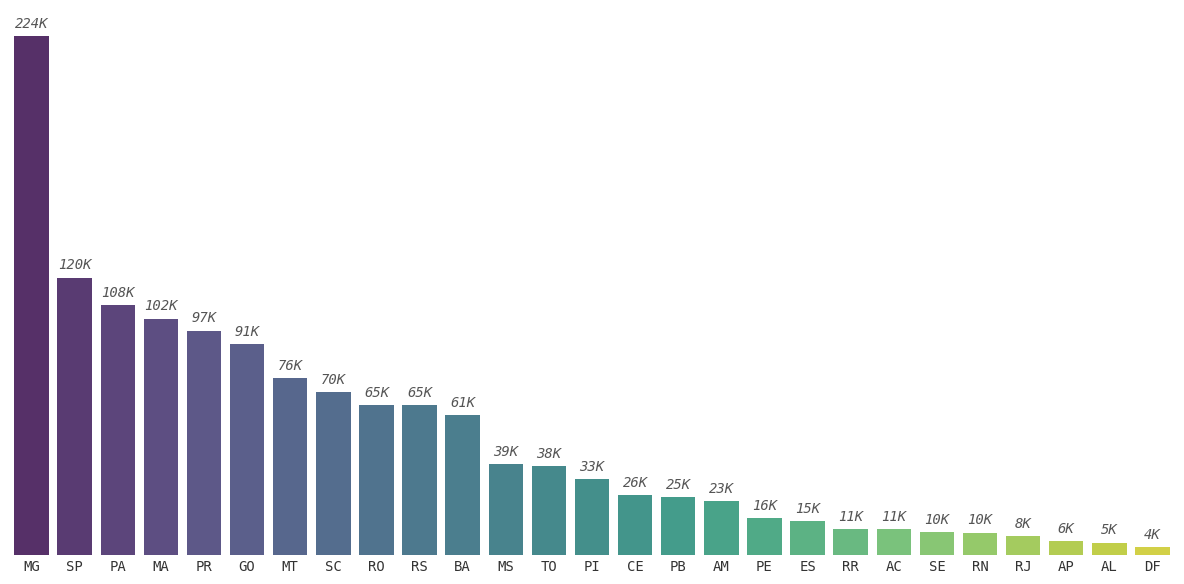

In [92]:
zt.bar_plot(df, 'uf', percentage=False)

### Histograma

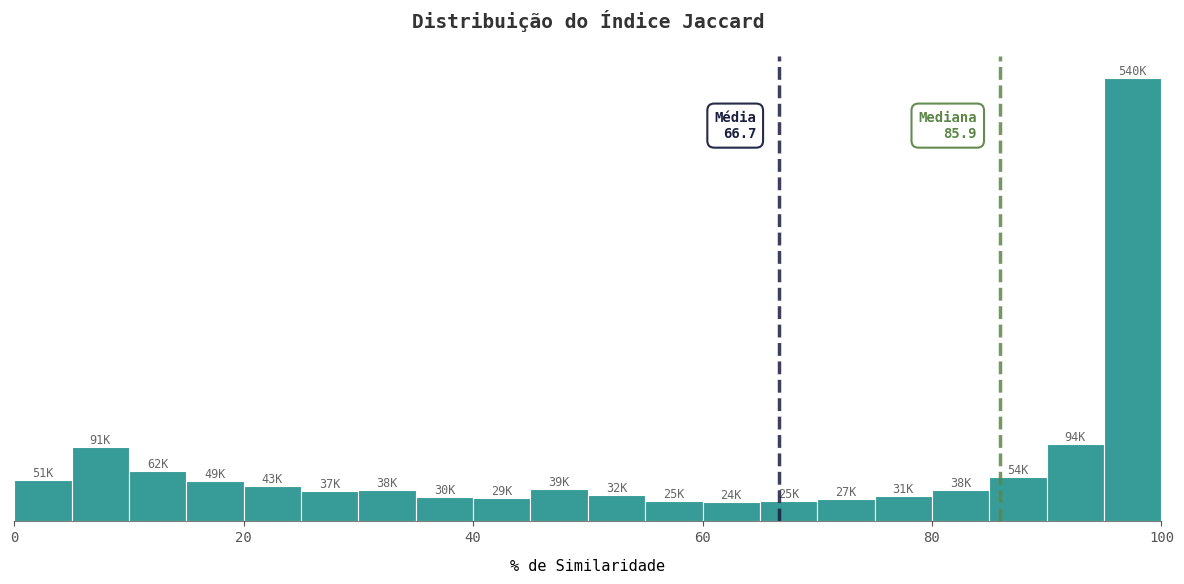

In [93]:
zt.hist_plot(df, 'indice_jaccard', xlabel='% de Similaridade', title='Distribuição do Índice Jaccard')

In [94]:
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import pandas as pd
import numpy as np

# --- 1. Preparação dos Dados (Agrupamento) ---
# Estamos criando uma Series multi-index com as contagens
# Mapeando os booleanos para textos legíveis para o gráfico
df['label_cpf'] = df['cpf_ok'].map({True: 'Titularidade\nIgual', False: 'Titularidade\nDiferente'})
df['label_geo'] = df['geo_ok'].map({True: 'Geo >= 85%', False: 'Geo < 85%'})

# Agrupando para contagem (Para Área, troque .size() por ['area_sicar_ha'].sum())
data_mosaic = df.groupby(['label_cpf', 'label_geo']).size()

# Ordenando para garantir que as cores batam certo (opcional, depende da ordem que sai do group)
# Vamos forçar uma ordem lógica se necessário, mas o dicionário de cores resolve.

# --- 2. Configuração Visual (Clean & Modern) ---

# Paleta de Cores "Flat" Moderna
colors = {
    ('Titularidade\nIgual', 'Geo >= 85%'):     '#2ecc71', # Verde (Validado)
    ('Titularidade\nIgual', 'Geo < 85%'):      '#f39c12', # Laranja (Erro Téc)
    ('Titularidade\nDiferente', 'Geo >= 85%'): '#f1c40f', # Amarelo (Alerta)
    ('Titularidade\nDiferente', 'Geo < 85%'):  '#e74c3c'  # Vermelho (Inconsistente)
}

# Função para aplicar as cores
def props(key):
    return {'color': colors[key], 'edgecolor': 'white', 'linewidth': 2}

# Função para gerar o texto de dentro (Labelizer)
total = data_mosaic.sum()
def labelizer(key):
    count = data_mosaic[key]
    perc = (count / total) * 100
    
    # Formatação inteligente dos números (K para milhar, M para milhão)
    if count > 1000000:
        count_str = f'{count/1000000:.1f}M'
    else:
        count_str = f'{count/1000:.0f}K'
        
    return f"{count_str}\n({perc:.1f}%)"

# --- 3. Plotagem ---
fig, ax = plt.subplots(figsize=(10, 7))

# Gerando o Mosaico
# gap=0.02 cria o espaçamento branco moderno entre os blocos
mosaic(data_mosaic, gap=0.02, properties=props, labelizer=labelizer, ax=ax, 
       title='', horizontal=True)

# --- 4. Ajustes Finais de Estilo (Removendo ruído) ---

# Aumentar fonte dos labels internos
for text in ax.texts:
    text.set_color('white') # Texto branco para contraste
    text.set_fontsize(11)
    text.set_fontweight('bold')
    # Ajuste para o texto amarelo (que tem fundo claro) ficar preto se preferir
    # if 'Alerta' in str(text): text.set_color('#333333') 

# Títulos dos Eixos (Customizados para ficar clean)
# O Statsmodels coloca labels automáticos feios, vamos limpar e colocar os nossos
ax.set_xlabel('Similaridade Espacial (SIGEF)', fontsize=12, labelpad=10, color='#555555')
ax.set_ylabel('Validação de Titularidade (CPF)', fontsize=12, labelpad=10, color='#555555')

# Título Principal
plt.suptitle('Segmentação da Base de Imóveis (Matriz de Risco)', 
             fontsize=16, fontweight='bold', color='#333333', y=0.98)

# Removendo bordas do gráfico (spines)
sns.despine(left=True, bottom=True)

plt.show()

KeyError: 'cpf_ok'

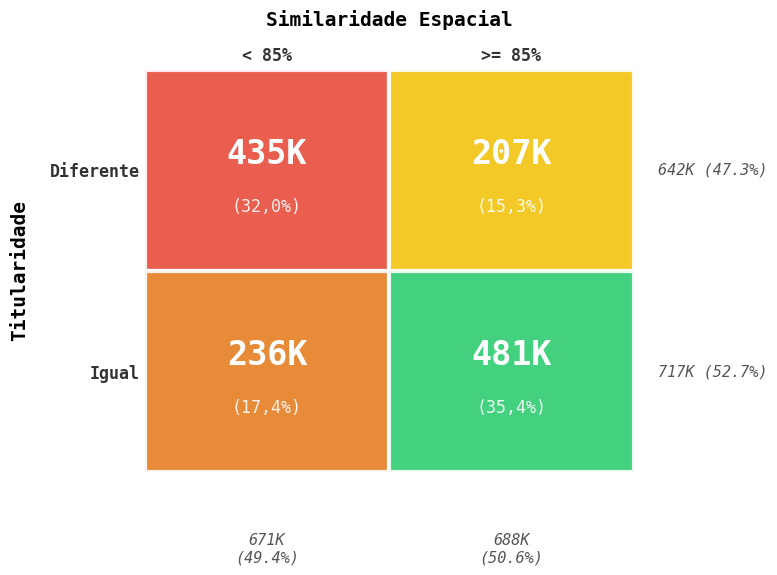

In [95]:
df['cpf_ok'] = df['igualdade_cpf'].apply(lambda x: str(x).upper() == 'TRUE')
df['geo_ok'] = df['indice_jaccard'] >= 85

cores_personalizadas = {
    (True, True): '#2ecc71',    # Verde - Coerente
    (True, False): '#e67e22',   # Laranja - Incoerência Espacial
    (False, True): '#f1c40f',   # Amarelo - Incoerência Titularidade
    (False, False): '#e74c3c'   # Vermelho - Incoerente
}

zt.risk_matrix_plot(
    df,
    row_col='cpf_ok',
    col_col='geo_ok',
    row_title='Titularidade',
    col_title='Similaridade Espacial',
    colors=cores_personalizadas,
    row_labels={True: 'Igual', False: 'Diferente'},
    col_labels={True: '>= 85%', False: '< 85%'},
    title=False,
    count_fontsize=12,
    figsize=(8,6)
)


### GARANTIA DE INTEGRIDADE DO ÍNDICE DE JACCARD

In [96]:
# União = Area_CAR + Area_SIGEF - Interseção
df['uniao_ha'] = df['area_sicar_ha'] + df['area_sigef_agregado_ha'] - df['area_intersecao_ha']

# Evitar divisão por zero
df['jaccard_calculado'] = df.apply(
    lambda x: x['area_intersecao_ha'] / x['uniao_ha'] if x['uniao_ha'] > 0 else 0, axis=1
)

df['jaccard_calculado'] = df['jaccard_calculado'].clip(upper=1.0)*100

In [97]:
df[['indice_jaccard', 'jaccard_calculado']].describe()

,indice_jaccard,jaccard_calculado
count,1.358932e+06,1.358932e+06
mean,6.667219e+01,6.667212e+01
std,3.592930e+01,3.592922e+01
min,0.000000e+00,6.990206e-04
25%,3.091000e+01,3.090927e+01
50%,8.593000e+01,8.593106e+01
75%,9.943000e+01,9.943068e+01
max,1.000000e+02,1.000000e+02


### Análise por Perfil do Imóvel

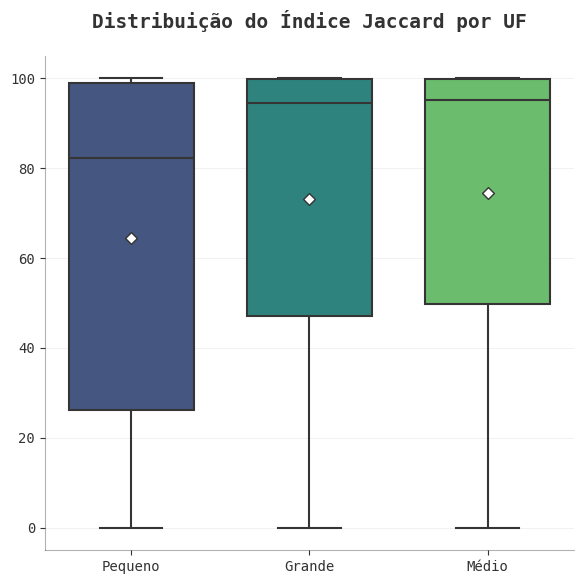

In [98]:
zt.box_plot(
    df, 
    y='indice_jaccard', 
    x='class_tam_imovel',
    title='Distribuição do Índice Jaccard por UF',
    figsize=(6,6)
)


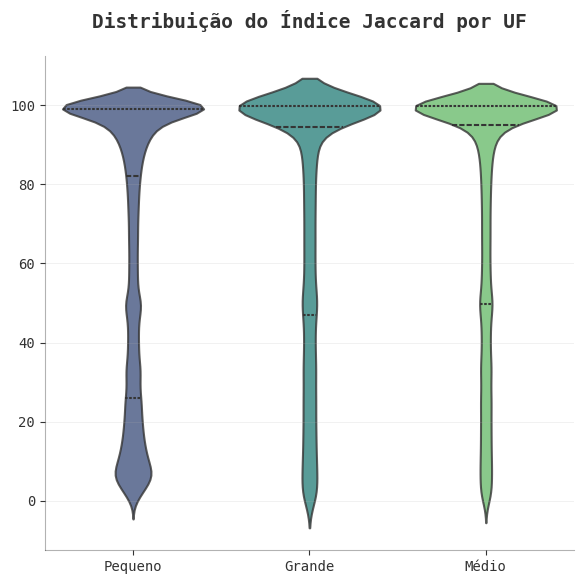

In [99]:
zt.violin_plot(
    df, 
    y='indice_jaccard', 
    x='class_tam_imovel',
    title='Distribuição do Índice Jaccard por UF',
    figsize=(6,6)
)


### Discrepância de área declarada (CAR) vs. georreferenciada (SIGEF)

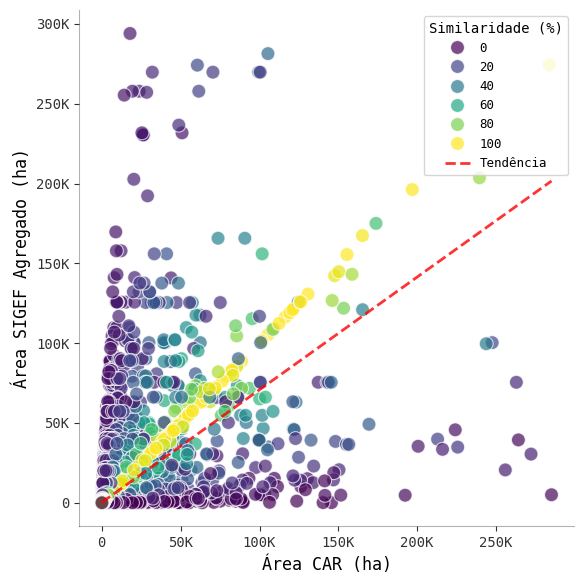

In [100]:
df_zoom = df[(df['area_sicar_ha'] < 300_000) & (df['area_sigef_agregado_ha'] < 300_000)]
zt.scatter_plot(df_zoom, 
                x='area_sicar_ha',
                y='area_sigef_agregado_ha',
                figsize=(6,6),
                hue='indice_jaccard',
                legend_title='Similaridade (%)',
                show_trend=True,
                legend_loc='upper right',
                use_suffix_x=True,
                use_suffix_y=True,
                ax_kwargs={'xlabel': 'Área CAR (ha)', 
                           'ylabel': 'Área SIGEF Agregado (ha)',})

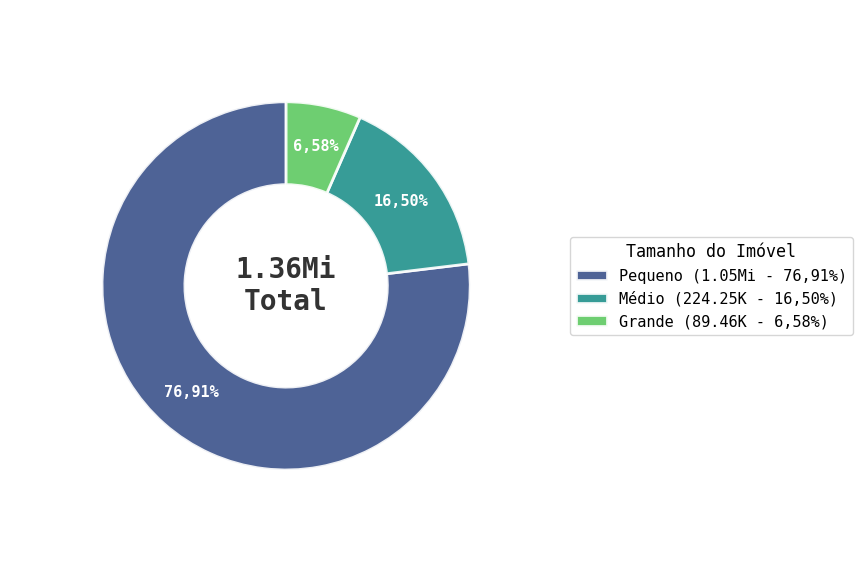

In [101]:
zt.donut_plot(df, 'class_tam_imovel', figsize=(8,6), legend_title='Tamanho do Imóvel', decimal_places=2)

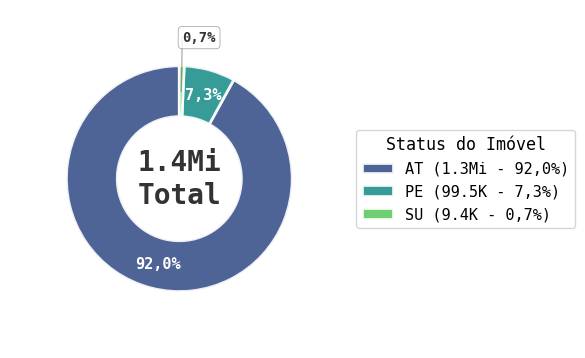

In [102]:
zt.donut_plot(df, 'status_imovel', legend_title='Status do Imóvel', figsize=(6,6))

### O Status do imóvel (Ativo, Pendente, Suspenso) tem correlação com a similaridade?

In [103]:


# 1. Preparar os grupos (igual você fez)
grupos = [df[df['class_tam_imovel'] == c]['indice_jaccard'] for c in df['class_tam_imovel'].unique()]

# 2. Rodar Kruskal-Wallis (Substituto da ANOVA para dados não normais)
H_stat, p_value = stats.kruskal(*grupos)

print(f"Estatística H: {H_stat}")
print(f"P-valor: {p_value}")

if p_value < 0.05:
    print("Resultado: Existe diferença significativa entre as medianas dos grupos.")
else:
    print("Resultado: Não há diferença significativa.")

# 3. Calcular o Tamanho do Efeito (Epsilon Squared - ε²)
# Fórmula: (H - k + 1) / (N - k)
# Onde H é a estatística do teste, k é o número de grupos, N é o total de observações

n = len(df)                      # Número total de observações
k = len(df['status_imovel'].unique()) # Número de grupos
epsilon_squared = (H_stat - k + 1) / (n - k)

print(f"\nEpsilon ao Quadrado (Força da Associação): {epsilon_squared:.4f}")

# Interpretação
if epsilon_squared < 0.01: print("Associação nula/desprezível")
elif epsilon_squared < 0.06: print("Associação pequena")
elif epsilon_squared < 0.14: print("Associação média")
else: print("Associação forte")

Estatística H: 21125.65113790458
P-valor: 0.0
Resultado: Existe diferença significativa entre as medianas dos grupos.

Epsilon ao Quadrado (Força da Associação): 0.0155
Associação pequena


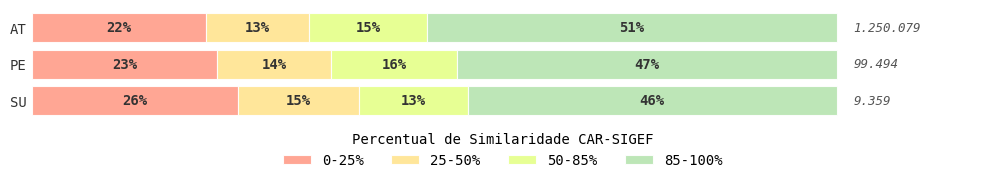

In [104]:
zt.stacked_bar_plot(
    df,
    y="status_imovel",
    hue="faixa_jaccard",
    order_hue=["0-25%", "25-50%", "50-85%", "85-100%"],
    palette=[ '#FF9D89', '#FFE48F', "#E5FF89",  '#B6E4B0'],
    legend_title="Percentual de Similaridade CAR-SIGEF",
    use_suffix=False,
    figsize=(10, 2)
)

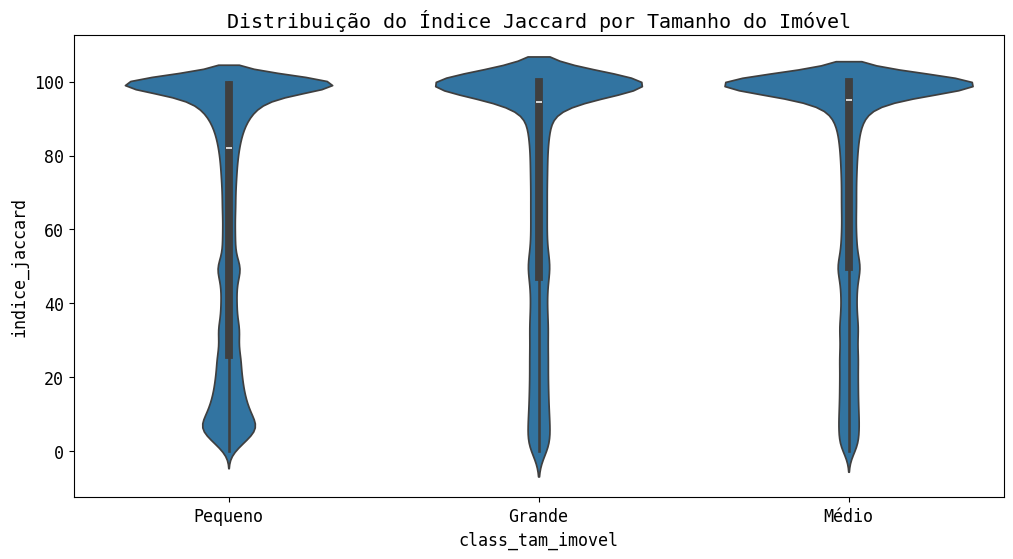

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Violin plot mostra melhor a densidade bimodal que o boxplot
sns.violinplot(x='class_tam_imovel', y='indice_jaccard', data=df)

plt.title('Distribuição do Índice Jaccard por Tamanho do Imóvel')
plt.show()

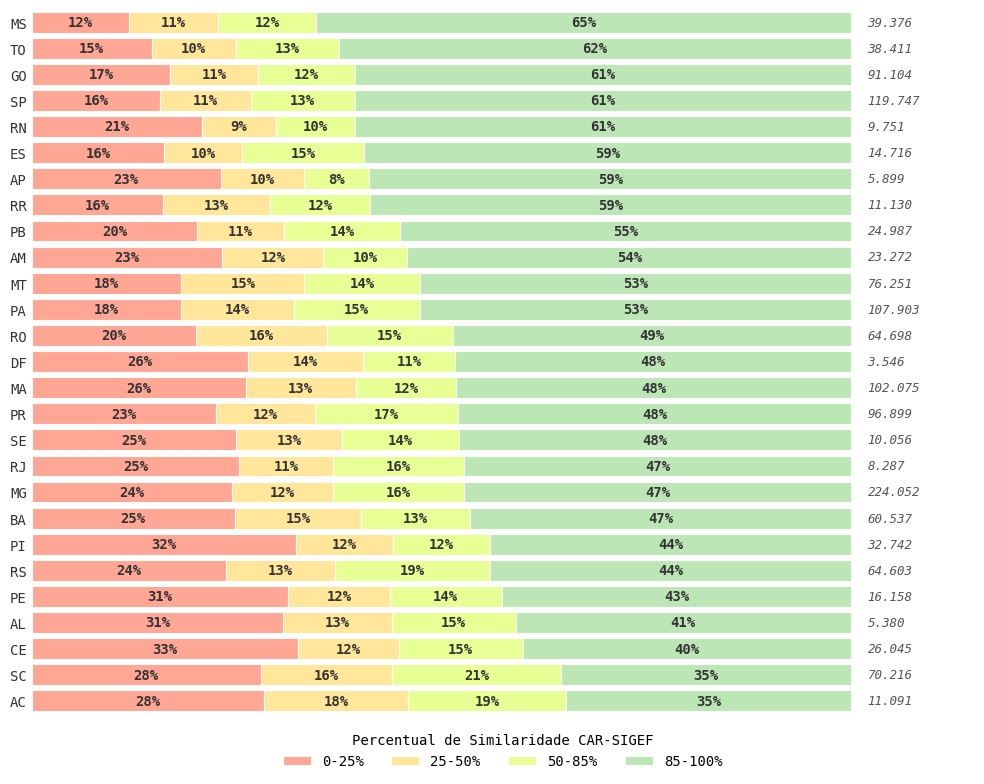

In [106]:
zt.stacked_bar_plot(
    df,
    y="uf",
    hue="faixa_jaccard",
    order_hue=["0-25%", "25-50%", "50-85%", "85-100%"],
    palette=[ '#FF9D89', '#FFE48F', "#E5FF89",  '#B6E4B0'],
    legend_title="Percentual de Similaridade CAR-SIGEF",
    use_suffix=False,
    figsize=(10, 8)
)

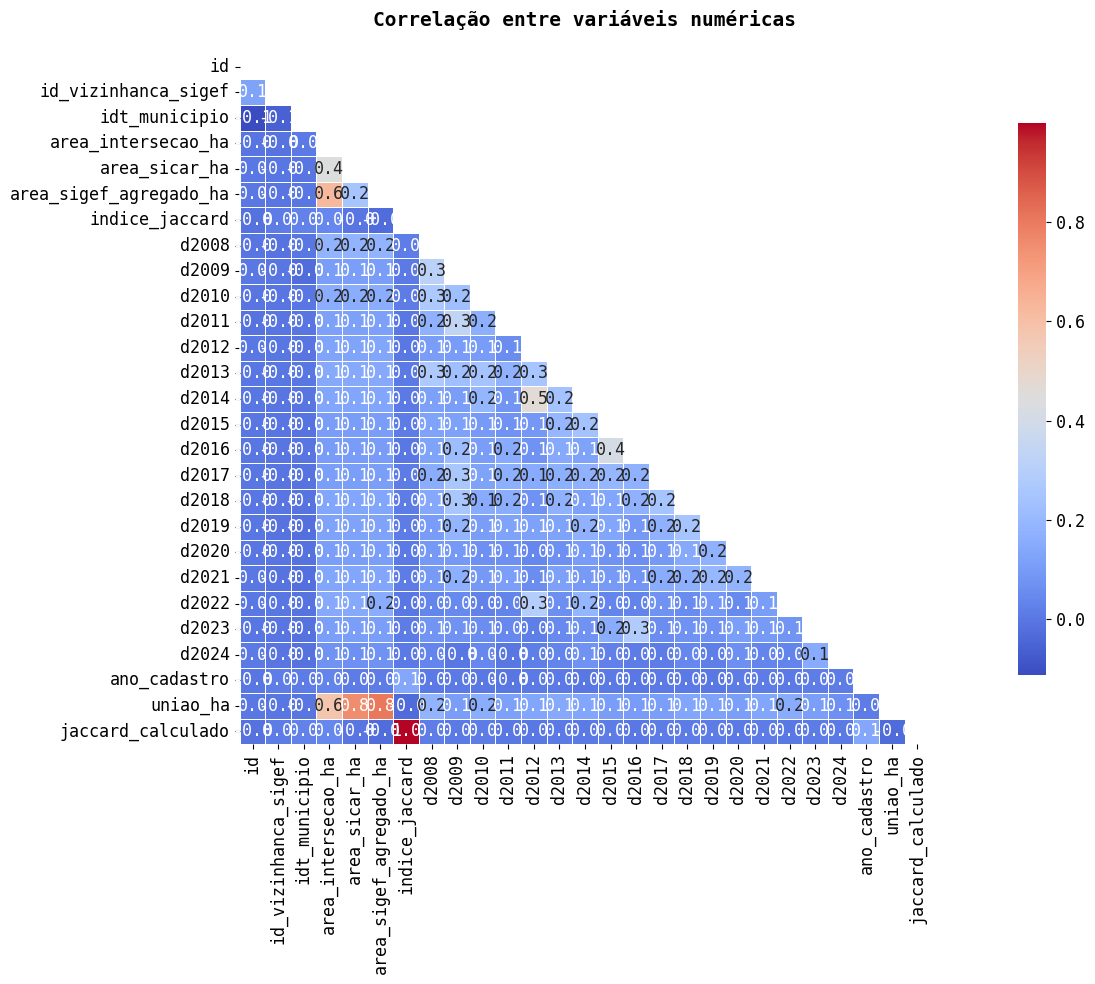

In [107]:
# Seleciona apenas colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calcula correlação
corr_matrix = df[numeric_cols].corr()

# Cria máscara para triângulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)

# Plota apenas triângulo superior
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, 
            mask=mask,
            cmap='coolwarm', 
            annot=True, 
            fmt='.1f', 
            linewidths=0.5,
            cbar=True, 
            cbar_kws={'shrink': 0.8},
            square=True)
plt.title('Correlação entre variáveis numéricas', pad=20, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Existem estados com pior qualidade de dados?

In [108]:
def format_number(num, use_suffix=True, decimal_places=0, decimal_sep=',', thousand_sep=','):
    """
    Formata números grandes com sufixos K, Mi, B
    
    Args:
        num: Número a ser formatado
        use_suffix: Se True, usa sufixos. Se False, usa separador de milhar
        decimal_places: Número de casas decimais. Default 0.
        decimal_sep: Separador decimal ('.' ou ','). Default '.'.
        thousand_sep: Separador de milhar (',' ou '.'). Default ','.
    
    Returns:
        String formatada
    """
    # ═══════════════════════════════════════════════════════════
    # 🔢 FORMATAÇÃO SEM SUFIXO
    # ═══════════════════════════════════════════════════════════
    if not use_suffix:
        if decimal_places > 0:
            formatted = f'{num:,.{decimal_places}f}'
        else:
            formatted = f'{int(num):,}'
        
        # Ajusta separadores
        if decimal_sep == ',':
            # Troca temporariamente para não conflitar
            formatted = formatted.replace(',', 'TEMP')
            formatted = formatted.replace('.', ',')
            formatted = formatted.replace('TEMP', '.')
        elif thousand_sep == '.':
            formatted = formatted.replace(',', '.')
        
        return formatted
    
    # ═══════════════════════════════════════════════════════════
    # 📊 FORMATAÇÃO COM SUFIXO
    # ═══════════════════════════════════════════════════════════
    thresholds = [
        (1_000_000_000, 'B'),
        (1_000_000, 'Mi'),
        (1_000, 'K'),
    ]
    
    for threshold, suffix in thresholds:
        if num >= threshold:
            value = num / threshold
            
            if decimal_places == 0 and value == int(value):
                return f'{int(value)}{suffix}'
            
            formatted = f'{value:.{decimal_places}f}'
            
            # Troca separador decimal se necessário
            if decimal_sep == ',':
                formatted = formatted.replace('.', ',')
            
            return f'{formatted}{suffix}'
    
    # ═══════════════════════════════════════════════════════════
    # 🔹 NÚMEROS PEQUENOS (< 1000)
    # ═══════════════════════════════════════════════════════════
    if decimal_places > 0:
        formatted = f'{num:,.{decimal_places}f}'
    else:
        formatted = f'{int(num):,}'
    
    # Ajusta separadores
    if decimal_sep == ',':
        formatted = formatted.replace(',', 'TEMP')
        formatted = formatted.replace('.', ',')
        formatted = formatted.replace('TEMP', '.')
    elif thousand_sep == '.':
        formatted = formatted.replace(',', '.')
    
    return formatted

In [109]:
def choropleth_plot(
    df,
    geo,
    value_col,
    geo_col=None,
    df_col=None,
    agg_func='mean',
    title='',
    subtitle='',
    palette='viridis',
    figsize=(12, 10),
    alpha=0.9,
    edgecolor='black',
    linewidth=0.5,
    crs='EPSG:4674',
    # ═══════════════════════════════════════════════════════════
    # Legenda
    # ═══════════════════════════════════════════════════════════
    legend=True,
    legend_title='',
    legend_orientation='horizontal',
    legend_position='bottom',
    legend_shrink=0.6,
    legend_pad=0.02,
    # ═══════════════════════════════════════════════════════════
    # Classificação
    # ═══════════════════════════════════════════════════════════
    scheme=None,
    k=5,
    vmin=None,
    vmax=None,
    categorical=False,
    category_order=None,
    # ═══════════════════════════════════════════════════════════
    # Labels e Valores
    # ═══════════════════════════════════════════════════════════
    show_labels=False,
    label_col=None,
    label_fontsize=8,
    label_color='#333',
    label_color_auto=False,
    show_values=False,
    value_fontsize=8,
    value_format='.1f',
    value_suffix='',
    value_prefix='',
    label_position='center',
    label_style='both',
    use_suffix=False,
    decimal_places=1,
    decimal_sep='.',
    thousand_sep=',',
    # ═══════════════════════════════════════════════════════════
    # Dados Faltantes
    # ═══════════════════════════════════════════════════════════
    missing_color='lightgray',
    missing_label='Sem dados',
    # ═══════════════════════════════════════════════════════════
    # Destaque
    # ═══════════════════════════════════════════════════════════
    highlight=None,
    highlight_color='red',
    highlight_linewidth=2,
    # ═══════════════════════════════════════════════════════════
    # 🧭 ROSA DOS VENTOS (NOVO)
    # ═══════════════════════════════════════════════════════════
    show_north_arrow=False,
    north_arrow_position='top-right',
    north_arrow_size=0.08,
    north_arrow_style='fancy',
    # ═══════════════════════════════════════════════════════════
    # 📏 BARRA DE ESCALA (NOVO)
    # ═══════════════════════════════════════════════════════════
    show_scalebar=False,
    scalebar_position='bottom-left',
    scalebar_length=None,
    scalebar_units='km',
    scalebar_fontsize=8,
    # ═══════════════════════════════════════════════════════════
    # 🖼️ MOLDURA (NOVO)
    # ═══════════════════════════════════════════════════════════
    show_frame=False,
    frame_linewidth=2,
    frame_color='black',
    # ═══════════════════════════════════════════════════════════
    # 🌐 GRID DE COORDENADAS (NOVO)
    # ═══════════════════════════════════════════════════════════
    show_gridlines=False,
    gridline_color='gray',
    gridline_alpha=0.3,
    gridline_style='--',
    show_gridline_labels=False,
    # ═══════════════════════════════════════════════════════════
    # 📝 ANOTAÇÕES E CRÉDITOS (NOVO)
    # ═══════════════════════════════════════════════════════════
    annotation=None,
    annotation_position='bottom-right',
    source=None,
    author=None,
    date=None,
    # ═══════════════════════════════════════════════════════════
    # 🏷️ LOGO (NOVO)
    # ═══════════════════════════════════════════════════════════
    logo_path=None,
    logo_position='bottom-left',
    logo_size=0.1
):
    """
    Plota um mapa coroplético profissional com elementos cartográficos.
    
    Args:
        ... (parâmetros anteriores) ...
        
        Rosa dos Ventos:
            show_north_arrow (bool): Mostra rosa dos ventos. Default False.
            north_arrow_position (str): 'top-right', 'top-left', 'bottom-right', 'bottom-left'.
            north_arrow_size (float): Tamanho relativo (0-1). Default 0.08.
            north_arrow_style (str): 'simple', 'fancy', 'arrow'. Default 'fancy'.
        
        Barra de Escala:
            show_scalebar (bool): Mostra barra de escala. Default False.
            scalebar_position (str): Posição da barra.
            scalebar_length (float): Comprimento em unidades (auto se None).
            scalebar_units (str): 'km' ou 'm'. Default 'km'.
            scalebar_fontsize (int): Tamanho da fonte.
        
        Moldura:
            show_frame (bool): Mostra moldura ao redor do mapa. Default False.
            frame_linewidth (int): Largura da moldura.
            frame_color (str): Cor da moldura.
        
        Grid de Coordenadas:
            show_gridlines (bool): Mostra linhas de grade. Default False.
            gridline_color (str): Cor das linhas.
            gridline_alpha (float): Transparência.
            show_gridline_labels (bool): Mostra rótulos lat/lon.
        
        Créditos:
            source (str): Fonte dos dados.
            author (str): Autor/instituição.
            date (str): Data de elaboração.
        
        Logo:
            logo_path (str): Caminho para imagem do logo.
            logo_position (str): Posição do logo.
            logo_size (float): Tamanho relativo.
    
    Returns:
        None
    """
    # ═══════════════════════════════════════════════════════════
    # 📁 CARREGAMENTO DOS DADOS GEOGRÁFICOS
    # ═══════════════════════════════════════════════════════════
    if isinstance(geo, str):
        gdf = gpd.read_file(geo)
    else:
        gdf = geo.copy()
    
    if gdf.crs != crs:
        gdf = gdf.to_crs(crs)
    
    # ═══════════════════════════════════════════════════════════
    # 📊 AGREGAÇÃO DOS DADOS
    # ═══════════════════════════════════════════════════════════
    df_merge_col = df_col if df_col else geo_col
    
    if agg_func is not None and df_merge_col is not None:
        if df[df_merge_col].duplicated().any():
            if categorical:
                df_agg = df.groupby(df_merge_col)[value_col].agg(
                    lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan
                ).reset_index()
            else:
                df_agg = df.groupby(df_merge_col)[value_col].agg(agg_func).reset_index()
            
            other_cols = [c for c in df.columns if c not in [df_merge_col, value_col]]
            if other_cols:
                df_other = df.groupby(df_merge_col)[other_cols].first().reset_index()
                df_agg = df_agg.merge(df_other, on=df_merge_col, how='left')
        else:
            df_agg = df.copy()
    else:
        df_agg = df.copy()
    
    # ═══════════════════════════════════════════════════════════
    # 🔗 MERGE DOS DADOS
    # ═══════════════════════════════════════════════════════════
    if geo_col is not None:
        map_data = gdf.merge(df_agg, left_on=geo_col, right_on=df_merge_col, how='left')
    else:
        map_data = gdf.copy()
        for col in df_agg.columns:
            if col not in map_data.columns:
                map_data[col] = df_agg[col].values
    
    # ═══════════════════════════════════════════════════════════
    # 🎨 CONFIGURAÇÃO DE CORES
    # ═══════════════════════════════════════════════════════════
    if isinstance(palette, str):
        try:
            cmap = sns.color_palette(palette, as_cmap=True)
        except:
            cmap = plt.cm.get_cmap(palette)
    else:
        cmap = palette
    
    # ═══════════════════════════════════════════════════════════
    # 📐 CRIAÇÃO DA FIGURA
    # ═══════════════════════════════════════════════════════════
    fig, ax = plt.subplots(figsize=figsize)
    
    # ═══════════════════════════════════════════════════════════
    # 📋 CONFIGURAÇÃO DA LEGENDA
    # ═══════════════════════════════════════════════════════════
    legend_kwds = {
        'shrink': legend_shrink,
        'label': legend_title,
        'pad': legend_pad,
    }
    
    if legend_orientation == 'horizontal':
        legend_kwds['orientation'] = 'horizontal'
        if legend_position == 'bottom':
            legend_kwds['location'] = 'bottom'
        elif legend_position == 'top':
            legend_kwds['location'] = 'top'
    else:
        legend_kwds['orientation'] = 'vertical'
        if legend_position == 'right':
            legend_kwds['location'] = 'right'
        elif legend_position == 'left':
            legend_kwds['location'] = 'left'
    
    # ═══════════════════════════════════════════════════════════
    # 🗺️ PLOTAGEM DO MAPA
    # ═══════════════════════════════════════════════════════════
    if categorical:
        if category_order:
            categories = category_order
        else:
            categories = map_data[value_col].dropna().unique()
        
        n_cats = len(categories)
        colors = sns.color_palette(palette, n_cats)
        color_dict = {cat: colors[i] for i, cat in enumerate(categories)}
        
        for cat in categories:
            mask = map_data[value_col] == cat
            map_data[mask].plot(
                ax=ax,
                color=color_dict[cat],
                edgecolor=edgecolor,
                linewidth=linewidth,
                alpha=alpha,
                label=str(cat)
            )
        
        mask_missing = map_data[value_col].isna()
        if mask_missing.any():
            map_data[mask_missing].plot(
                ax=ax,
                color=missing_color,
                edgecolor=edgecolor,
                linewidth=linewidth,
                alpha=alpha,
                label=missing_label
            )
        
        if legend:
            ax.legend(
                title=legend_title or value_col,
                loc='upper right',
                frameon=True,
                fancybox=True,
                fontsize=10
            )
    
    elif scheme:
        scheme_map = {
            'equal_interval': 'EqualInterval',
            'quantiles': 'Quantiles',
            'natural_breaks': 'NaturalBreaks',
            'std_mean': 'StdMean',
            'percentiles': 'Percentiles',
            'fisher_jenks': 'FisherJenks'
        }
        
        scheme_name = scheme_map.get(scheme, scheme)
        
        map_data.plot(
            column=value_col,
            cmap=cmap,
            linewidth=linewidth,
            edgecolor=edgecolor,
            legend=legend,
            ax=ax,
            alpha=alpha,
            scheme=scheme_name,
            k=k,
            legend_kwds={
                'title': legend_title or value_col,
                'loc': 'upper right',
                'fontsize': 9
            },
            missing_kwds={
                'color': missing_color,
                'edgecolor': edgecolor,
                'linewidth': linewidth,
                'label': missing_label
            }
        )
    
    else:
        map_data.plot(
            column=value_col,
            cmap=cmap,
            linewidth=linewidth,
            edgecolor=edgecolor,
            legend=legend,
            ax=ax,
            alpha=alpha,
            legend_kwds=legend_kwds,
            missing_kwds={
                'color': missing_color,
                'edgecolor': edgecolor,
                'linewidth': linewidth,
                'label': missing_label
            },
            vmin=vmin,
            vmax=vmax
        )
    
    # ═══════════════════════════════════════════════════════════
    # ✨ DESTAQUE DE GEOMETRIAS
    # ═══════════════════════════════════════════════════════════
    if highlight and geo_col:
        highlight_mask = map_data[geo_col].isin(highlight)
        map_data[highlight_mask].plot(
            ax=ax,
            facecolor='none',
            edgecolor=highlight_color,
            linewidth=highlight_linewidth,
            zorder=5
        )
    
    # ═══════════════════════════════════════════════════════════
    # 🏷️ LABELS E VALORES NAS GEOMETRIAS
    # ═══════════════════════════════════════════════════════════
    if show_labels or show_values:
        label_column = label_col or geo_col
        
        if label_color_auto and not categorical:
            val_min = map_data[value_col].min()
            val_max = map_data[value_col].max()
        
        for idx, row in map_data.iterrows():
            centroid = row.geometry.centroid
            
            label_text = ''
            value_text = ''
            
            if show_labels and label_column and pd.notna(row.get(label_column)):
                label_text = str(row[label_column])
            
            if show_values and pd.notna(row.get(value_col)):
                if use_suffix:
                    value_text = format_number(
                        row[value_col], 
                        use_suffix=True, 
                        decimal_places=decimal_places,
                        decimal_sep=decimal_sep,
                        thousand_sep=thousand_sep
                    )
                else:
                    value_text = f'{row[value_col]:{value_format}}'
                    if decimal_sep == ',':
                        value_text = value_text.replace('.', ',')
                
                value_text = f'{value_prefix}{value_text}{value_suffix}'
            
            if label_style == 'label':
                final_text = label_text
            elif label_style == 'value':
                final_text = value_text
            elif label_style == 'both_line':
                parts = [p for p in [label_text, value_text] if p]
                final_text = '\n'.join(parts)
            else:
                parts = [p for p in [label_text, value_text] if p]
                final_text = ' '.join(parts)
            
            if not final_text:
                continue
            
            if label_color_auto and not categorical:
                if pd.notna(row.get(value_col)):
                    if val_max > val_min:
                        norm_val = (row[value_col] - val_min) / (val_max - val_min)
                    else:
                        norm_val = 0.5
                    bg_color = cmap(norm_val)
                    luminance = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
                    text_color = 'white' if luminance < 0.5 else '#333'
                else:
                    text_color = label_color
            else:
                text_color = label_color
            
            if label_position == 'top':
                va = 'bottom'
                y_offset = 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])
                y_pos = centroid.y + y_offset
            elif label_position == 'bottom':
                va = 'top'
                y_offset = 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])
                y_pos = centroid.y - y_offset
            else:
                va = 'center'
                y_pos = centroid.y
            
            ax.annotate(
                final_text,
                xy=(centroid.x, y_pos),
                ha='center',
                va=va,
                fontsize=label_fontsize if show_labels else value_fontsize,
                color=text_color,
                fontweight='bold',
                path_effects=[
                    plt.matplotlib.patheffects.withStroke(linewidth=2, foreground='white')
                ] if not label_color_auto else None
            )
    
    # ═══════════════════════════════════════════════════════════
    # 🧭 ROSA DOS VENTOS
    # ═══════════════════════════════════════════════════════════
    if show_north_arrow:
        _add_north_arrow(ax, position=north_arrow_position, 
                        size=north_arrow_size, style=north_arrow_style)
    
    # ═══════════════════════════════════════════════════════════
    # 📏 BARRA DE ESCALA
    # ═══════════════════════════════════════════════════════════
    if show_scalebar:
        _add_scalebar(ax, map_data, position=scalebar_position,
                     length=scalebar_length, units=scalebar_units,
                     fontsize=scalebar_fontsize)
    
    # ═══════════════════════════════════════════════════════════
    # 🌐 GRID DE COORDENADAS
    # ═══════════════════════════════════════════════════════════
    if show_gridlines:
        ax.grid(True, color=gridline_color, alpha=gridline_alpha, 
                linestyle=gridline_style, zorder=0)
        
        if show_gridline_labels:
            ax.tick_params(axis='both', which='major', labelsize=8, colors='#666')
            ax.set_xlabel('Longitude', fontsize=9, color='#666')
            ax.set_ylabel('Latitude', fontsize=9, color='#666')
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    
    # ═══════════════════════════════════════════════════════════
    # 🖼️ MOLDURA
    # ═══════════════════════════════════════════════════════════
    if show_frame:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(frame_linewidth)
            spine.set_color(frame_color)
    else:
        ax.axis('off')
    
    # ═══════════════════════════════════════════════════════════
    # 📝 TÍTULO E SUBTÍTULO
    # ═══════════════════════════════════════════════════════════
    if title:
        ax.set_title(title, fontsize=16, fontweight='bold', color='#333', pad=20)
    
    if subtitle:
        ax.text(
            0.5, 1.02,
            subtitle,
            transform=ax.transAxes,
            ha='center',
            va='bottom',
            fontsize=11,
            color='#666',
            fontstyle='italic'
        )
    
    # ═══════════════════════════════════════════════════════════
    # 📝 CRÉDITOS (FONTE, AUTOR, DATA)
    # ═══════════════════════════════════════════════════════════
    credits_parts = []
    if source:
        credits_parts.append(f'Fonte: {source}')
    if author:
        credits_parts.append(f'Elaboração: {author}')
    if date:
        credits_parts.append(f'Data: {date}')
    
    if credits_parts or annotation:
        credit_text = ' | '.join(credits_parts)
        if annotation:
            credit_text = f'{annotation}\n{credit_text}' if credit_text else annotation
        
        positions = {
            'bottom-right': (0.98, 0.02, 'right', 'bottom'),
            'bottom-left': (0.02, 0.02, 'left', 'bottom'),
            'top-right': (0.98, 0.98, 'right', 'top'),
            'top-left': (0.02, 0.98, 'left', 'top'),
        }
        
        x_pos, y_pos, ha, va = positions.get(annotation_position, positions['bottom-right'])
        
        ax.annotate(
            credit_text,
            xy=(x_pos, y_pos),
            xycoords='axes fraction',
            ha=ha,
            va=va,
            fontsize=8,
            color='#555',
            fontstyle='italic',
            bbox=dict(
                facecolor='white',
                edgecolor='none',
                alpha=0.7,
                pad=2
            )
        )
    
    # ═══════════════════════════════════════════════════════════
    # 🏷️ LOGO
    # ═══════════════════════════════════════════════════════════
    if logo_path:
        _add_logo(ax, logo_path, position=logo_position, size=logo_size)
    
    plt.tight_layout()
    plt.show()


# ═══════════════════════════════════════════════════════════════════════════
# 🧭 FUNÇÃO AUXILIAR: ROSA DOS VENTOS
# ═══════════════════════════════════════════════════════════════════════════
def _add_north_arrow(ax, position='top-right', size=0.08, style='fancy'):
    """Adiciona rosa dos ventos ao mapa."""
    
    # Calcula posição
    positions = {
        'top-right': (0.95, 0.95),
        'top-left': (0.05, 0.95),
        'bottom-right': (0.95, 0.15),
        'bottom-left': (0.05, 0.15),
    }
    x, y = positions.get(position, (0.95, 0.95))
    
    if style == 'simple':
        # Seta simples
        ax.annotate(
            'N',
            xy=(x, y),
            xycoords='axes fraction',
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold',
            color='#333'
        )
        ax.annotate(
            '',
            xy=(x, y),
            xytext=(x, y - size),
            xycoords='axes fraction',
            arrowprops=dict(
                arrowstyle='-|>',
                color='#333',
                lw=2
            )
        )
    
    elif style == 'fancy':
        # Rosa dos ventos estilizada
        from matplotlib.patches import FancyArrowPatch, Circle
        from matplotlib.transforms import Bbox
        
        # Obtém os limites do eixo em coordenadas de dados
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        # Calcula posição em coordenadas de dados
        arrow_x = xlim[0] + x * (xlim[1] - xlim[0])
        arrow_y = ylim[0] + y * (ylim[1] - ylim[0])
        
        # Tamanho da seta em coordenadas de dados
        arrow_length = size * (ylim[1] - ylim[0])
        arrow_width = arrow_length * 0.3
        
        # Seta do norte (preta)
        ax.annotate(
            '',
            xy=(arrow_x, arrow_y),
            xytext=(arrow_x, arrow_y - arrow_length),
            arrowprops=dict(
                arrowstyle='fancy,head_length=0.8,head_width=0.5,tail_width=0.2',
                fc='#333',
                ec='#333',
                lw=1
            ),
            zorder=10
        )
        
        # Letra N
        ax.text(
            arrow_x, arrow_y + arrow_length * 0.15,
            'N',
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='bold',
            color='#333',
            zorder=10
        )
    
    elif style == 'arrow':
        # Seta tradicional com círculo
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        arrow_x = xlim[0] + x * (xlim[1] - xlim[0])
        arrow_y = ylim[0] + y * (ylim[1] - ylim[0])
        arrow_length = size * (ylim[1] - ylim[0])
        
        # Círculo de fundo
        circle = plt.Circle(
            (arrow_x, arrow_y - arrow_length * 0.3),
            arrow_length * 0.5,
            fill=True,
            facecolor='white',
            edgecolor='#333',
            linewidth=1.5,
            zorder=9
        )
        ax.add_patch(circle)
        
        # Seta
        ax.annotate(
            '',
            xy=(arrow_x, arrow_y),
            xytext=(arrow_x, arrow_y - arrow_length * 0.6),
            arrowprops=dict(
                arrowstyle='-|>,head_length=0.6,head_width=0.4',
                fc='#333',
                ec='#333',
                lw=2
            ),
            zorder=10
        )
        
        # Letra N
        ax.text(
            arrow_x, arrow_y + arrow_length * 0.1,
            'N',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold',
            color='#333',
            zorder=10
        )


# ═══════════════════════════════════════════════════════════════════════════
# 📏 FUNÇÃO AUXILIAR: BARRA DE ESCALA
# ═══════════════════════════════════════════════════════════════════════════
def _add_scalebar(ax, gdf, position='bottom-left', length=None, 
                  units='km', fontsize=8):
    """Adiciona barra de escala ao mapa."""
    
    # Calcula extensão do mapa
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    map_width = bounds[2] - bounds[0]
    map_height = bounds[3] - bounds[1]
    
    # Se não especificado, calcula comprimento automático (cerca de 1/5 da largura)
    if length is None:
        # Aproximação: 1 grau ≈ 111 km no equador
        approx_km = map_width * 111
        
        # Escolhe um valor "bonito" para a escala
        nice_values = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
        target = approx_km / 5
        length = min(nice_values, key=lambda x: abs(x - target))
    
    # Converte para graus (aproximação)
    length_degrees = length / 111  # km para graus
    
    if units == 'm':
        length_degrees = length / 111000
        label = f'{int(length)} m'
    else:
        label = f'{int(length)} km'
    
    # Posição da barra
    positions = {
        'bottom-left': (0.05, 0.05),
        'bottom-right': (0.95, 0.05),
        'top-left': (0.05, 0.95),
        'top-right': (0.95, 0.95),
    }
    x_frac, y_frac = positions.get(position, (0.05, 0.05))
    
    # Calcula posição em coordenadas de dados
    x_pos = bounds[0] + x_frac * map_width
    y_pos = bounds[1] + y_frac * map_height
    
    # Ajusta se estiver à direita
    if 'right' in position:
        x_pos = x_pos - length_degrees
    
    # Desenha a barra
    bar_height = map_height * 0.008
    
    # Retângulo preto
    ax.add_patch(plt.Rectangle(
        (x_pos, y_pos),
        length_degrees / 2, bar_height,
        facecolor='black',
        edgecolor='black',
        linewidth=0.5,
        zorder=10
    ))
    
    # Retângulo branco
    ax.add_patch(plt.Rectangle(
        (x_pos + length_degrees / 2, y_pos),
        length_degrees / 2, bar_height,
        facecolor='white',
        edgecolor='black',
        linewidth=0.5,
        zorder=10
    ))
    
    # Borda externa
    ax.add_patch(plt.Rectangle(
        (x_pos, y_pos),
        length_degrees, bar_height,
        facecolor='none',
        edgecolor='black',
        linewidth=1,
        zorder=10
    ))
    
    # Texto
    ax.text(
        x_pos + length_degrees / 2,
        y_pos + bar_height * 1.5,
        label,
        ha='center',
        va='bottom',
        fontsize=fontsize,
        fontweight='bold',
        color='#333',
        zorder=10
    )


# ═══════════════════════════════════════════════════════════════════════════
# 🏷️ FUNÇÃO AUXILIAR: LOGO
# ═══════════════════════════════════════════════════════════════════════════
def _add_logo(ax, logo_path, position='bottom-left', size=0.1):
    """Adiciona logo ao mapa."""
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    from PIL import Image
    
    try:
        img = Image.open(logo_path)
        
        positions = {
            'bottom-left': (0.05, 0.05),
            'bottom-right': (0.95, 0.05),
            'top-left': (0.05, 0.95),
            'top-right': (0.95, 0.95),
        }
        x, y = positions.get(position, (0.05, 0.05))
        
        # Calcula zoom baseado no tamanho desejado
        fig_width = ax.figure.get_figwidth() * ax.figure.dpi
        zoom = (size * fig_width) / max(img.size)
        
        imagebox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(
            imagebox, (x, y),
            xycoords='axes fraction',
            frameon=False,
            box_alignment=(0.5, 0.5)
        )
        ax.add_artist(ab)
    except Exception as e:
        print(f"Aviso: Não foi possível carregar o logo: {e}")

In [110]:
df_agrupado = df.groupby('uf')['indice_jaccard'].mean().reset_index()

choropleth_plot(
    df=df_agrupado,  # 27 registros (1 por UF)
    geo='../dados/BR_UF_2024.shp',
    value_col='indice_jaccard',
    geo_col='SIGLA_UF',
    show_labels=True,
    show_values=True,
    value_suffix='%',
    df_col='uf',
    decimal_sep=',',
    legend=False,
    show_north_arrow=True
)

DataSourceError: ../dados/BR_UF_2024.shp: No such file or directory

In [111]:
df_agrupado = df.groupby('uf')['indice_jaccard'].median().reset_index()

choropleth_plot(
    df=df_agrupado,  # 27 registros (1 por UF)
    geo='../dados/BR_UF_2024.shp',
    value_col='indice_jaccard',
    geo_col='SIGLA_UF',
    show_labels=True,
    show_values=True,
    value_suffix='%',
    df_col='uf',
    decimal_sep=',',
    legend=True,
    show_north_arrow=True,
    show_scalebar=True,
    source='IBGE/CAR/SIGEF',
    author='Caio M. L. Silva/Zetta',
    date='2025',
    show_gridlines=True,
    show_gridline_labels=True
)

DataSourceError: ../dados/BR_UF_2024.shp: No such file or directory

### Qualidade dos cadastros melhorou ao longo dos anos?

In [116]:
def line_plot(
    df,
    x,
    y,
    hue=None,
    title='',
    palette='viridis',
    figsize=(12, 6),
    alpha=0.9,
    linewidth=2,
    linestyle='-',
    marker=None,
    markersize=6,
    # ═══════════════════════════════════════════════════════════
    # Área e Preenchimento
    # ═══════════════════════════════════════════════════════════
    fill=False,
    fill_alpha=0.2,
    fill_between=None,
    ci=None,
    ci_alpha=0.2,
    # ═══════════════════════════════════════════════════════════
    # Média Móvel e Tendência
    # ═══════════════════════════════════════════════════════════
    show_trend=False,
    trend_type='linear',
    trend_color='red',
    trend_linestyle='--',
    trend_linewidth=1.5,
    moving_average=None,
    ma_color=None,
    ma_linewidth=1.5,
    ma_linestyle='-',
    # ═══════════════════════════════════════════════════════════
    # Valores e Anotações
    # ═══════════════════════════════════════════════════════════
    show_values=False,
    value_fontsize=8,
    value_format='.1f',
    value_suffix='',
    value_prefix='',
    decimal_sep='.',
    annotate_points=None,
    annotate_fontsize=9,
    # ═══════════════════════════════════════════════════════════
    # Eventos e Períodos
    # ═══════════════════════════════════════════════════════════
    events=None,
    event_color='red',
    event_linestyle='--',
    event_alpha=0.7,
    highlight_periods=None,
    highlight_color='yellow',
    highlight_alpha=0.2,
    # ═══════════════════════════════════════════════════════════
    # Linhas de Referência
    # ═══════════════════════════════════════════════════════════
    hlines=None,
    hline_colors='gray',
    hline_styles=':',
    hline_labels=None,
    vlines=None,
    vline_colors='gray',
    vline_styles=':',
    vline_labels=None,
    # ═══════════════════════════════════════════════════════════
    # Eixos
    # ═══════════════════════════════════════════════════════════
    xlabel=None,
    ylabel=None,
    xlim=None,
    ylim=None,
    y2=None,
    y2_label=None,
    y2_color='red',
    # ═══════════════════════════════════════════════════════════
    # Formatação de Datas
    # ═══════════════════════════════════════════════════════════
    date_format=None,
    date_interval=None,
    rotate_labels=0,
    # ═══════════════════════════════════════════════════════════
    # Legenda e Grid
    # ═══════════════════════════════════════════════════════════
    legend=True,
    legend_title=None,
    legend_position='best',
    show_grid=True,
    grid_axis='both',
    grid_alpha=0.3,
    # ═══════════════════════════════════════════════════════════
    # Ordenação
    # ═══════════════════════════════════════════════════════════
    sort_x=True,
    order_hue=None
):
    """
    Plota gráfico de linha temporal com opções avançadas.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada.
        x (str): Coluna para o eixo X (geralmente data/tempo).
        y (str ou list): Coluna(s) para o eixo Y.
        hue (str, optional): Coluna para agrupar linhas por cor. Default None.
        title (str, optional): Título do gráfico. Default ''.
        palette (str, optional): Paleta de cores. Default 'viridis'.
        figsize (tuple, optional): Tamanho da figura. Default (12, 6).
        alpha (float, optional): Opacidade das linhas. Default 0.9.
        linewidth (float, optional): Largura das linhas. Default 2.
        linestyle (str, optional): Estilo das linhas. Default '-'.
        marker (str, optional): Marcador nos pontos. Default None.
        markersize (int, optional): Tamanho dos marcadores. Default 6.
        
        Área e Preenchimento:
            fill (bool): Preenche área sob a linha. Default False.
            fill_alpha (float): Opacidade do preenchimento. Default 0.2.
            fill_between (tuple): Preenche entre duas colunas (col1, col2).
            ci (float): Intervalo de confiança (ex: 95). Default None.
            ci_alpha (float): Opacidade do intervalo. Default 0.2.
        
        Tendência:
            show_trend (bool): Mostra linha de tendência. Default False.
            trend_type (str): 'linear', 'polynomial', 'exponential'. Default 'linear'.
            moving_average (int): Janela da média móvel. Default None.
        
        Valores:
            show_values (bool): Mostra valores nos pontos. Default False.
            value_format (str): Formato dos valores. Default '.1f'.
            decimal_sep (str): Separador decimal. Default '.'.
        
        Eventos:
            events (dict): Eventos para marcar {data: 'label'}. Default None.
            highlight_periods (list): Períodos para destacar [(inicio, fim, label)].
        
        Referência:
            hlines (list): Linhas horizontais de referência.
            vlines (list): Linhas verticais de referência.
        
        Eixos:
            y2 (str): Coluna para eixo Y secundário. Default None.
            date_format (str): Formato de data (ex: '%b/%Y'). Default None.
            date_interval (int): Intervalo entre labels de data.
        
        Legenda:
            legend (bool): Mostra legenda. Default True.
            legend_position (str): Posição da legenda. Default 'best'.
        
    Returns:
        None
    """
    # ═══════════════════════════════════════════════════════════
    # 📊 PREPARAÇÃO DOS DADOS
    # ═══════════════════════════════════════════════════════════
    df_plot = df.copy()
    
    # Ordena por x se necessário
    if sort_x:
        df_plot = df_plot.sort_values(x)
    
    # Converte para datetime se necessário
    if df_plot[x].dtype == 'object':
        try:
            df_plot[x] = pd.to_datetime(df_plot[x])
        except:
            pass
    
    # Lista de colunas Y
    if isinstance(y, str):
        y_cols = [y]
    else:
        y_cols = list(y)
    
    # ═══════════════════════════════════════════════════════════
    # 🎨 CONFIGURAÇÃO DE CORES
    # ═══════════════════════════════════════════════════════════
    if hue:
        n_colors = df_plot[hue].nunique()
    else:
        n_colors = len(y_cols)
    
    colors = sns.color_palette(palette, n_colors)
    
    # ═══════════════════════════════════════════════════════════
    # 📐 CRIAÇÃO DA FIGURA
    # ═══════════════════════════════════════════════════════════
    fig, ax = plt.subplots(figsize=figsize)
    
    # ═══════════════════════════════════════════════════════════
    # 📈 PLOTAGEM DAS LINHAS
    # ═══════════════════════════════════════════════════════════
    
    lines = []
    labels = []
    
    # ───────────────────────────────────────────────────────────
    # Com agrupamento por hue
    # ───────────────────────────────────────────────────────────
    if hue:
        groups = order_hue if order_hue else df_plot[hue].unique()
        
        for i, group in enumerate(groups):
            mask = df_plot[hue] == group
            group_data = df_plot[mask]
            
            line, = ax.plot(
                group_data[x],
                group_data[y_cols[0]],
                color=colors[i],
                linewidth=linewidth,
                linestyle=linestyle,
                marker=marker,
                markersize=markersize,
                alpha=alpha,
                label=str(group)
            )
            lines.append(line)
            labels.append(str(group))
            
            # Preenchimento
            if fill:
                ax.fill_between(
                    group_data[x],
                    group_data[y_cols[0]],
                    alpha=fill_alpha,
                    color=colors[i]
                )
    
    # ───────────────────────────────────────────────────────────
    # Múltiplas colunas Y
    # ───────────────────────────────────────────────────────────
    else:
        for i, y_col in enumerate(y_cols):
            line, = ax.plot(
                df_plot[x],
                df_plot[y_col],
                color=colors[i],
                linewidth=linewidth,
                linestyle=linestyle,
                marker=marker,
                markersize=markersize,
                alpha=alpha,
                label=y_col
            )
            lines.append(line)
            labels.append(y_col)
            
            # Preenchimento
            if fill:
                ax.fill_between(
                    df_plot[x],
                    df_plot[y_col],
                    alpha=fill_alpha,
                    color=colors[i]
                )
    
    # ═══════════════════════════════════════════════════════════
    # 📊 PREENCHIMENTO ENTRE LINHAS
    # ═══════════════════════════════════════════════════════════
    if fill_between:
        col1, col2 = fill_between
        ax.fill_between(
            df_plot[x],
            df_plot[col1],
            df_plot[col2],
            alpha=fill_alpha,
            color=colors[0],
            label=f'{col1} - {col2}'
        )
    
    # ═══════════════════════════════════════════════════════════
    # 📉 INTERVALO DE CONFIANÇA
    # ═══════════════════════════════════════════════════════════
    if ci and hue:
        for i, group in enumerate(groups):
            mask = df_plot[hue] == group
            group_data = df_plot[mask].groupby(x)[y_cols[0]].agg(['mean', 'std']).reset_index()
            
            z = 1.96 if ci == 95 else 2.576 if ci == 99 else 1.645
            
            ax.fill_between(
                group_data[x],
                group_data['mean'] - z * group_data['std'],
                group_data['mean'] + z * group_data['std'],
                alpha=ci_alpha,
                color=colors[i]
            )
    
    # ═══════════════════════════════════════════════════════════
    # 📈 MÉDIA MÓVEL
    # ═══════════════════════════════════════════════════════════
    if moving_average:
        for i, y_col in enumerate(y_cols):
            ma = df_plot[y_col].rolling(window=moving_average, center=True).mean()
            
            ma_c = ma_color if ma_color else colors[i]
            
            ax.plot(
                df_plot[x],
                ma,
                color=ma_c,
                linewidth=ma_linewidth,
                linestyle=ma_linestyle,
                alpha=0.8,
                label=f'{y_col} (MM{moving_average})'
            )
    
    # ═══════════════════════════════════════════════════════════
    # 📊 LINHA DE TENDÊNCIA
    # ═══════════════════════════════════════════════════════════
    if show_trend:
        for i, y_col in enumerate(y_cols):
            # Converte x para numérico se for data
            if pd.api.types.is_datetime64_any_dtype(df_plot[x]):
                x_numeric = (df_plot[x] - df_plot[x].min()).dt.total_seconds()
            else:
                x_numeric = df_plot[x].astype(float)
            
            if trend_type == 'linear':
                z = np.polyfit(x_numeric, df_plot[y_col], 1)
                p = np.poly1d(z)
            elif trend_type == 'polynomial':
                z = np.polyfit(x_numeric, df_plot[y_col], 2)
                p = np.poly1d(z)
            else:
                # Exponencial
                try:
                    from scipy.optimize import curve_fit
                    def exp_func(x, a, b):
                        return a * np.exp(b * x)
                    popt, _ = curve_fit(exp_func, x_numeric, df_plot[y_col], maxfev=5000)
                    p = lambda x: exp_func(x, *popt)
                except:
                    z = np.polyfit(x_numeric, df_plot[y_col], 1)
                    p = np.poly1d(z)
            
            ax.plot(
                df_plot[x],
                p(x_numeric),
                color=trend_color,
                linewidth=trend_linewidth,
                linestyle=trend_linestyle,
                alpha=0.8,
                label=f'Tendência ({trend_type})'
            )
    
    # ═══════════════════════════════════════════════════════════
    # 📊 EIXO Y SECUNDÁRIO
    # ═══════════════════════════════════════════════════════════
    if y2:
        ax2 = ax.twinx()
        
        ax2.plot(
            df_plot[x],
            df_plot[y2],
            color=y2_color,
            linewidth=linewidth,
            linestyle='--',
            marker=marker,
            markersize=markersize,
            alpha=alpha,
            label=y2
        )
        
        ax2.set_ylabel(y2_label or y2, color=y2_color, fontsize=11)
        ax2.tick_params(axis='y', labelcolor=y2_color)
        ax2.spines['right'].set_color(y2_color)
    
    # ═══════════════════════════════════════════════════════════
    # 🏷️ VALORES NOS PONTOS
    # ═══════════════════════════════════════════════════════════
    if show_values:
        for i, y_col in enumerate(y_cols if not hue else [y_cols[0]]):
            if hue:
                for group in groups:
                    mask = df_plot[hue] == group
                    group_data = df_plot[mask]
                    
                    for _, row in group_data.iterrows():
                        value_text = f'{row[y_col]:{value_format}}'
                        if decimal_sep == ',':
                            value_text = value_text.replace('.', ',')
                        value_text = f'{value_prefix}{value_text}{value_suffix}'
                        
                        ax.annotate(
                            value_text,
                            (row[x], row[y_col]),
                            textcoords="offset points",
                            xytext=(0, 8),
                            ha='center',
                            fontsize=value_fontsize,
                            color='#555'
                        )
            else:
                for _, row in df_plot.iterrows():
                    value_text = f'{row[y_col]:{value_format}}'
                    if decimal_sep == ',':
                        value_text = value_text.replace('.', ',')
                    value_text = f'{value_prefix}{value_text}{value_suffix}'
                    
                    ax.annotate(
                        value_text,
                        (row[x], row[y_col]),
                        textcoords="offset points",
                        xytext=(0, 8),
                        ha='center',
                        fontsize=value_fontsize,
                        color='#555'
                    )
    
    # ═══════════════════════════════════════════════════════════
    # 📍 ANOTAÇÕES EM PONTOS ESPECÍFICOS
    # ═══════════════════════════════════════════════════════════
    if annotate_points:
        for point in annotate_points:
            x_val = point.get('x')
            y_val = point.get('y')
            text = point.get('text', '')
            offset = point.get('offset', (10, 10))
            
            ax.annotate(
                text,
                (x_val, y_val),
                textcoords="offset points",
                xytext=offset,
                ha='left',
                fontsize=annotate_fontsize,
                fontweight='bold',
                arrowprops=dict(
                    arrowstyle='->',
                    color='#333',
                    connectionstyle='arc3,rad=0.2'
                ),
                bbox=dict(
                    facecolor='white',
                    edgecolor='gray',
                    boxstyle='round,pad=0.3',
                    alpha=0.9
                )
            )
    
    # ═══════════════════════════════════════════════════════════
    # 📅 EVENTOS (LINHAS VERTICAIS COM LABELS)
    # ═══════════════════════════════════════════════════════════
    if events:
        for event_x, event_label in events.items():
            ax.axvline(
                x=event_x,
                color=event_color,
                linestyle=event_linestyle,
                alpha=event_alpha,
                linewidth=1.5
            )
            
            ax.text(
                event_x,
                ax.get_ylim()[1],
                f' {event_label}',
                rotation=90,
                va='top',
                ha='left',
                fontsize=8,
                color=event_color,
                fontweight='bold'
            )
    
    # ═══════════════════════════════════════════════════════════
    # 🟨 PERÍODOS DESTACADOS
    # ═══════════════════════════════════════════════════════════
    if highlight_periods:
        for period in highlight_periods:
            start, end = period[0], period[1]
            label = period[2] if len(period) > 2 else None
            color = period[3] if len(period) > 3 else highlight_color
            
            ax.axvspan(
                start, end,
                alpha=highlight_alpha,
                color=color,
                label=label
            )
    
    # ═══════════════════════════════════════════════════════════
    # 📏 LINHAS DE REFERÊNCIA HORIZONTAIS
    # ═══════════════════════════════════════════════════════════
    if hlines:
        if not isinstance(hlines, list):
            hlines = [hlines]
        
        h_colors = [hline_colors] * len(hlines) if isinstance(hline_colors, str) else hline_colors
        h_styles = [hline_styles] * len(hlines) if isinstance(hline_styles, str) else hline_styles
        h_labels = hline_labels if hline_labels else [None] * len(hlines)
        
        for i, hline in enumerate(hlines):
            ax.axhline(
                y=hline,
                color=h_colors[i] if i < len(h_colors) else 'gray',
                linestyle=h_styles[i] if i < len(h_styles) else ':',
                alpha=0.7,
                linewidth=1.5
            )
            
            if h_labels[i]:
                ax.text(
                    ax.get_xlim()[1],
                    hline,
                    f' {h_labels[i]}',
                    va='center',
                    ha='left',
                    fontsize=8,
                    color=h_colors[i] if i < len(h_colors) else 'gray'
                )
    
    # ═══════════════════════════════════════════════════════════
    # 📏 LINHAS DE REFERÊNCIA VERTICAIS
    # ═══════════════════════════════════════════════════════════
    if vlines:
        if not isinstance(vlines, list):
            vlines = [vlines]
        
        v_colors = [vline_colors] * len(vlines) if isinstance(vline_colors, str) else vline_colors
        v_styles = [vline_styles] * len(vlines) if isinstance(vline_styles, str) else vline_styles
        v_labels = vline_labels if vline_labels else [None] * len(vlines)
        
        for i, vline in enumerate(vlines):
            ax.axvline(
                x=vline,
                color=v_colors[i] if i < len(v_colors) else 'gray',
                linestyle=v_styles[i] if i < len(v_styles) else ':',
                alpha=0.7,
                linewidth=1.5
            )
            
            if v_labels[i]:
                ax.text(
                    vline,
                    ax.get_ylim()[1],
                    f' {v_labels[i]}',
                    rotation=90,
                    va='top',
                    ha='left',
                    fontsize=8,
                    color=v_colors[i] if i < len(v_colors) else 'gray'
                )
    
    # ═══════════════════════════════════════════════════════════
    # 📅 FORMATAÇÃO DE DATAS
    # ═══════════════════════════════════════════════════════════
    if date_format:
        import matplotlib.dates as mdates
        ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
        
        if date_interval:
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=date_interval))
    
    if rotate_labels:
        plt.xticks(rotation=rotate_labels, ha='right')
    
    # ═══════════════════════════════════════════════════════════
    # 🎨 ESTILIZAÇÃO FINAL
    # ═══════════════════════════════════════════════════════════
    ax.set_xlabel(xlabel or x, fontsize=11, labelpad=10)
    ax.set_ylabel(ylabel or (y_cols[0] if len(y_cols) == 1 else ''), fontsize=11, labelpad=10)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) if not y2 else None
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.3)
    
    ax.tick_params(axis='both', colors='#333', labelsize=10)
    
    if show_grid:
        ax.grid(True, axis=grid_axis, alpha=grid_alpha, linestyle='-', linewidth=0.5)
    
    # Limites dos eixos
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    
    # ═══════════════════════════════════════════════════════════
    # 📋 LEGENDA
    # ═══════════════════════════════════════════════════════════
    if legend and (len(y_cols) > 1 or hue or moving_average or show_trend):
        ax.legend(
            title=legend_title,
            loc=legend_position,
            frameon=True,
            fancybox=True,
            shadow=False,
            fontsize=10
        )
    
    # ═══════════════════════════════════════════════════════════
    # 📝 TÍTULO E FINALIZAÇÃO
    # ═══════════════════════════════════════════════════════════
    if title:
        ax.set_title(title, pad=20, fontsize=14, fontweight='bold', color='#333')
    
    plt.tight_layout()
    plt.show()

In [117]:
df.head()

,regiao_analise,id,id_vizinhanca_sigef,cod_imovel,idt_municipio,uf,tipo_imovel,status_imovel,data_cadastro_imovel,class_tam_imovel,...,d2021,d2022,d2023,d2024,faixa_jaccard,ano_cadastro,cpf_ok,geo_ok,uniao_ha,jaccard_calculado
0,Centro-Oeste,1,4254,DF-5300108-0000AE7221F4458582BE077E36495213,5300108,DF,IRU,AT,2019-05-14 19:30:08.576,Pequeno,...,0.0,0.0,0.0,0.0,85-100%,2019.0,True,True,9.8442,99.991873
1,Centro-Oeste,3,104768,DF-5300108-000246B53E6048558354E03CA022873A,5300108,DF,IRU,AT,2019-12-12 10:53:36.353,Pequeno,...,0.0,0.0,0.0,0.0,85-100%,2019.0,True,True,7.3723,99.911832
2,Centro-Oeste,4,83470,DF-5300108-0012FAB5934B416386711DBD527BD708,5300108,DF,IRU,AT,2025-05-23 08:31:22.331,Grande,...,NaN,NaN,NaN,NaN,85-100%,2025.0,False,True,172.2236,93.077430
3,Centro-Oeste,5,21259,DF-5300108-00152EAC5FCF453B845A5097E3336B64,5300108,DF,IRU,AT,2015-07-01 20:23:54.907,Grande,...,NaN,NaN,NaN,NaN,50-85%,2015.0,False,False,786.0870,51.882629
4,Centro-Oeste,6,129143,DF-5300108-001C3919F6B4464C838FFF35E022B147,5300108,DF,IRU,AT,2016-05-02 18:52:52.896,Pequeno,...,NaN,NaN,NaN,NaN,85-100%,2016.0,False,True,2.0598,99.975726


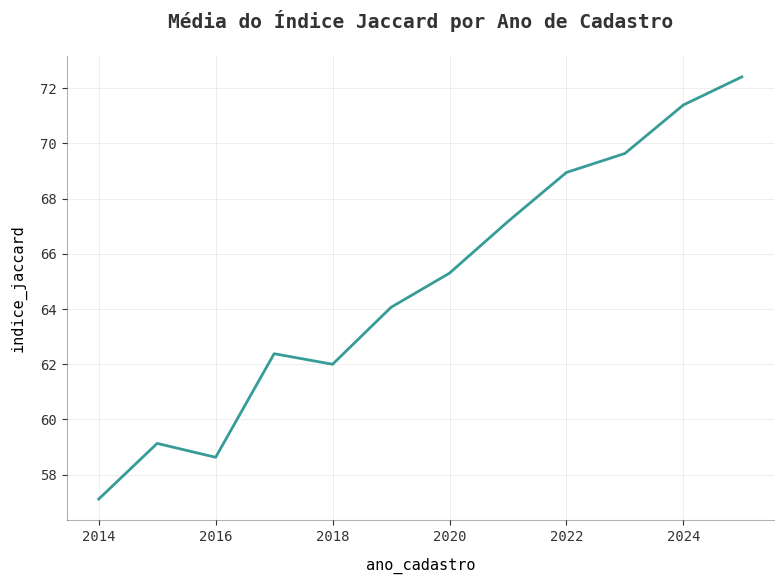

In [118]:
df_agrupado = df.groupby(['ano_cadastro'])['indice_jaccard'].mean().reset_index()
line_plot(df_agrupado, x='ano_cadastro', y='indice_jaccard', title='Média do Índice Jaccard por Ano de Cadastro', figsize=(8,6), show_trend=False)

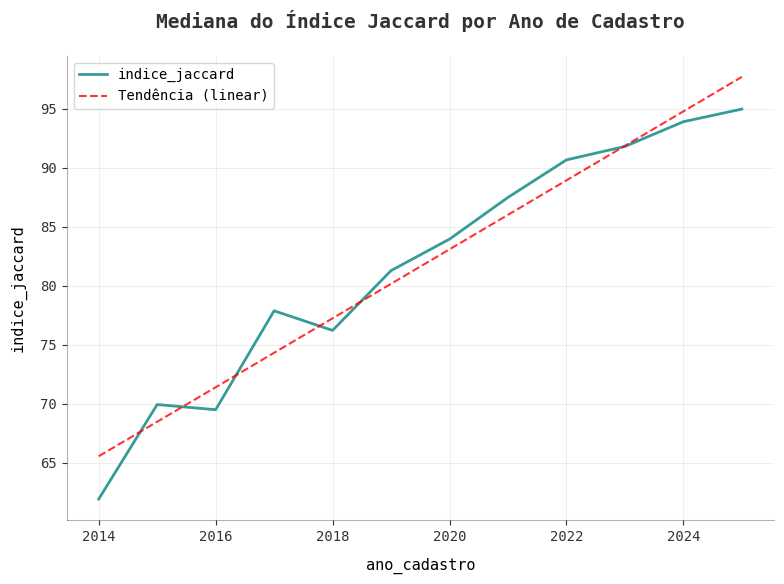

In [119]:
df_agrupado = df.groupby(['ano_cadastro'])['indice_jaccard'].median().reset_index()
line_plot(df_agrupado, x='ano_cadastro', y='indice_jaccard', title='Mediana do Índice Jaccard por Ano de Cadastro', figsize=(8,6), show_trend=True)